# Propensity Score Calibration

We use a toy example to demonstrate the calibration of propensity scores generated by a simple GaussianNB model.


## Reproduce sci-kit learn example

First, we reproduce a simple "three-blob" sci-kit learn example which illustrates how using a CalibratedClassifierCV improves propensity predictions under both "isotonic" and "sigmoid" methods.

In this example, we fit a GaussianNB model to a population containing three blobs and essentially one predictive covariate (see graph):

- bottom left (all class 0, treatment propensity=0)
- middle (50/50 mix of purple and red, treatment propensity=0.5)
- top right (all class 1, treatment propensity=1)

We see that the isotonic calibration performs better than sigmoid calibration.


In [1]:
# Following example at:
# https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration.html#sphx-glr-auto-examples-calibration-plot-calibration-py

In [2]:
import numpy as np

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

n_samples = 50000

# Generate 3 blobs with 2 classes where the second blob contains
# half positive samples and half negative samples. Probability in this
# blob is therefore 0.5.
centers = [(-5, -5), (0, 0), (5, 5)]
X, y = make_blobs(n_samples=n_samples, centers=centers, shuffle=False, random_state=42)

y[: n_samples // 2] = 0
y[n_samples // 2 :] = 1
sample_weight = np.random.RandomState(42).rand(y.shape[0])

# split train, test for calibration
X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(
    X, y, sample_weight, test_size=0.9, random_state=42
)

In [3]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from sklearn.naive_bayes import GaussianNB

# With no calibration
clf = GaussianNB()
clf.fit(X_train, y_train)  # GaussianNB itself does not support sample-weights
prob_pos_clf = clf.predict_proba(X_test)[:, 1]

# With isotonic calibration
clf_isotonic = CalibratedClassifierCV(clf, cv=2, method="isotonic")
clf_isotonic.fit(X_train, y_train, sample_weight=sw_train)
prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]

# With sigmoid calibration
clf_sigmoid = CalibratedClassifierCV(clf, cv=2, method="sigmoid")
clf_sigmoid.fit(X_train, y_train, sample_weight=sw_train)
prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]

print("Brier score losses: (the smaller the better)")

clf_score = brier_score_loss(y_test, prob_pos_clf, sample_weight=sw_test)
print("No calibration: %1.3f" % clf_score)

clf_isotonic_score = brier_score_loss(y_test, prob_pos_isotonic, sample_weight=sw_test)
print("With isotonic calibration: %1.3f" % clf_isotonic_score)

clf_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoid, sample_weight=sw_test)
print("With sigmoid calibration: %1.3f" % clf_sigmoid_score)

Brier score losses: (the smaller the better)
No calibration: 0.104
With isotonic calibration: 0.084
With sigmoid calibration: 0.109


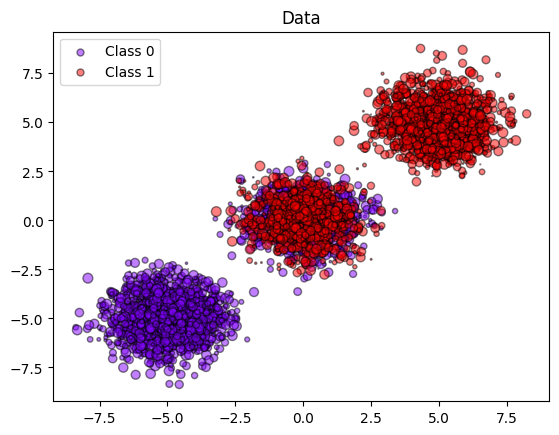

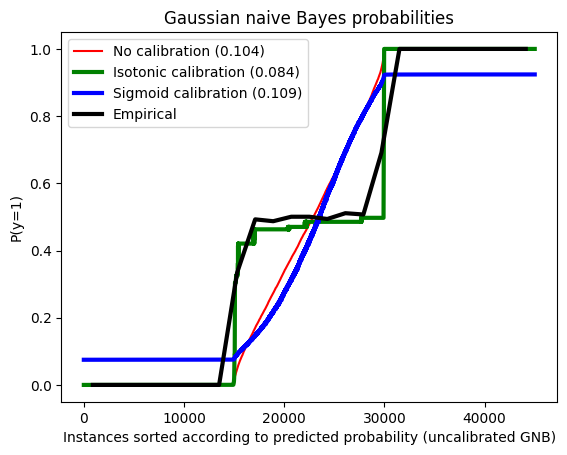

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm

plt.figure()
y_unique = np.unique(y)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X_train[y_train == this_y]
    this_sw = sw_train[y_train == this_y]
    plt.scatter(
        this_X[:, 0],
        this_X[:, 1],
        s=this_sw * 50,
        c=color[np.newaxis, :],
        alpha=0.5,
        edgecolor="k",
        label="Class %s" % this_y,
    )
plt.legend(loc="best")
plt.title("Data")

plt.figure()

order = np.lexsort((prob_pos_clf,))
plt.plot(prob_pos_clf[order], "r", label="No calibration (%1.3f)" % clf_score)
plt.plot(
    prob_pos_isotonic[order],
    "g",
    linewidth=3,
    label="Isotonic calibration (%1.3f)" % clf_isotonic_score,
)
plt.plot(
    prob_pos_sigmoid[order],
    "b",
    linewidth=3,
    label="Sigmoid calibration (%1.3f)" % clf_sigmoid_score,
)
plt.plot(
    np.linspace(0, y_test.size, 51)[1::2],
    y_test[order].reshape(25, -1).mean(1),
    "k",
    linewidth=3,
    label=r"Empirical",
)
plt.ylim([-0.05, 1.05])
plt.xlabel("Instances sorted according to predicted probability (uncalibrated GNB)")
plt.ylabel("P(y=1)")
plt.legend(loc="upper left")
plt.title("Gaussian naive Bayes probabilities")

plt.show()

# Modify above example to use IsotonicRegression 

We now work through the above example using IsotonicRegression and without CalibratedClassifierCV.  To use calibrate with IsotonicRegression, we follow the framework implemented in CausalML's `propensity.py` and define two functions `calibrate_iso(...)` and `compute_propensity_score(...)`.


In [5]:
import logging
from sklearn.isotonic import IsotonicRegression

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

%matplotlib inline

In [7]:
from causalml.propensity import (
    ElasticNetPropensityModel,
    GradientBoostedPropensityModel,
    LogisticRegressionPropensityModel,
)

In [8]:
def calibrate_iso(ps, treatment):
    """Calibrate propensity scores with IsotonicRegression.

    Ref: https://scikit-learn.org/stable/modules/isotonic.html

    Args:
        ps (numpy.array): a propensity score vector
        treatment (numpy.array): a binary treatment vector (0: control, 1: treated)

    Returns:
        (numpy.array): a calibrated propensity score vector
    """

    print("calibrate_iso")
    two_eps = 2.0 * np.finfo(float).eps
    pm_ir = IsotonicRegression(out_of_bounds="clip", y_min=two_eps, y_max=1.0 - two_eps)
    ps_ir = pm_ir.fit_transform(ps, treatment)

    return ps_ir


def compute_propensity_score(
    X, treatment, p_model=None, X_pred=None, treatment_pred=None, calibrate_p="iso"
):
    """Generate propensity score if user didn't provide

    Args:
        X (np.matrix): features for training
        treatment (np.array or pd.Series): a treatment vector for training
        p_model (propensity model object, optional):
            ElasticNetPropensityModel (default) / GradientBoostedPropensityModel
        X_pred (np.matrix, optional): features for prediction
        treatment_pred (np.array or pd.Series, optional): a treatment vector for prediciton
        calibrate_p (bool, optional): whether calibrate the propensity score

    Returns:
        (tuple)
            - p (numpy.ndarray): propensity score
            - p_model (PropensityModel): a trained PropensityModel object
    """

    print("using local compute_propensity_score")
    
    if treatment_pred is None:
        treatment_pred = treatment.copy()
    if p_model is None:
        p_model = ElasticNetPropensityModel()

    p_model.fit(X, treatment)

    if X_pred is None:
        try:
            p = p_model.predict_proba(X)[:, 1]
        except AttributeError:
            print("predict_proba not available, using predict instead")            
            p = p_model.predict(X)        
    else:
        try:
            p = p_model.predict_proba(X_pred)[:, 1]
        except AttributeError:
            print("predict_proba not available, using predict instead")            
            p = p_model.predict(X_pred)

    if calibrate_p == "iso":
        print("Isotonic calibrating propensity scores only.  Returning model=None.")
        p = calibrate_iso(p, treatment_pred)
        p_model = None
    elif calibrate_p == "pygam":
        print("pyGAM calibrating propensity scores only.  Returning model=None.")
        p = calibrate_pygam(p, treatment_pred)
        p_model = None

    # force the p values within the range
    eps = np.finfo(float).eps
    p = np.where(p < 0 + eps, 0 + eps * 1.001, p)
    p = np.where(p > 1 - eps, 1 - eps * 1.001, p)

    return p, p_model

##  Calculate the uncalibrated propensity scores 

In [9]:
# Without calibration, naive Bayes
cml_prob_pos_uc, psm_cps_uc = compute_propensity_score(X_train, y_train, p_model=clf, X_pred=X_test, calibrate_p=False)


using local compute_propensity_score


In [10]:
# With isotonic calibration
cml_prob_pos_cal_iso, psm_cps_cal_iso = compute_propensity_score(X_train, y_train, p_model=clf, X_pred=X_test, treatment_pred=y_test, calibrate_p="iso")


using local compute_propensity_score
Isotonic calibrating propensity scores only.  Returning model=None.
calibrate_iso


In [11]:
print("Brier score losses: (the smaller the better)")

cml_uc_score = brier_score_loss(y_test, cml_prob_pos_uc)
print("No calibration: %1.3f" % cml_uc_score)

cml_cal_iso_score = brier_score_loss(y_test, cml_prob_pos_cal_iso)
print("With isotonic calibration: %1.3f" % cml_cal_iso_score)


Brier score losses: (the smaller the better)
No calibration: 0.104
With isotonic calibration: 0.083


## Plot result

We confirm that using the CausalML calibration method using `IsotonicRegression` performs similarly to the `CalibratedClassifierCV` method in the original example, and that both match the empircal distribution better than the uncalibrated Naïve Bayes scores.

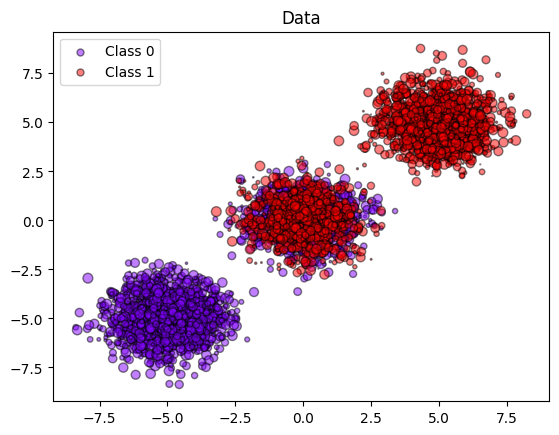

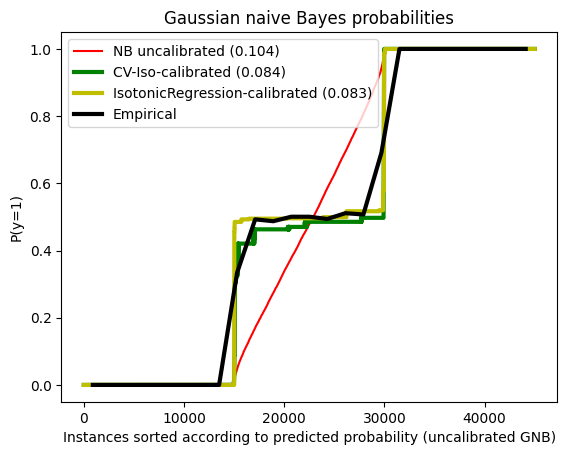

In [12]:
import matplotlib.pyplot as plt
from matplotlib import cm

plt.figure()
y_unique = np.unique(y)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X_train[y_train == this_y]
    this_sw = sw_train[y_train == this_y]
    plt.scatter(
        this_X[:, 0],
        this_X[:, 1],
        s=this_sw * 50,
        c=color[np.newaxis, :],
        alpha=0.5,
        edgecolor="k",
        label="Class %s" % this_y,
    )
plt.legend(loc="best")
plt.title("Data")

plt.figure()

order = np.lexsort((prob_pos_clf,))
# plt.plot(prob_pos_clf[order], "r", label="No calibration (%1.3f)" % clf_score)
plt.plot(
    cml_prob_pos_uc[order],
    "r",
    # linewidth=3,
    # linestyle="--",
    label="NB uncalibrated (%1.3f)" % cml_uc_score,
)
plt.plot(
    prob_pos_isotonic[order],
    "g",
    linewidth=3,
    label="CV-Iso-calibrated (%1.3f)" % clf_isotonic_score,
)
plt.plot(
    cml_prob_pos_cal_iso[order],
    "y",
    linewidth=3,
    linestyle="-",
    label="IsotonicRegression-calibrated (%1.3f)" % cml_cal_iso_score,
)
plt.plot(
    np.linspace(0, y_test.size, 51)[1::2],
    y_test[order].reshape(25, -1).mean(1),
    "k",
    linewidth=3,
    label=r"Empirical",
)
plt.ylim([-0.05, 1.05])
plt.xlabel("Instances sorted according to predicted probability (uncalibrated GNB)")
plt.ylabel("P(y=1)")
plt.legend(loc="upper left")
plt.title("Gaussian naive Bayes probabilities")

plt.show()